In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path
import scipy.stats
import time

from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, fitGMM
from open_spiel.python.examples.ubc_utils import *
import open_spiel.python.examples.ubc_dispatch as dispatch

from auctions.webutils import *

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from open_spiel.python.examples.ubc_cma import *

output_notebook()
from open_spiel.python.games.clock_auction_base import InformationPolicy, ActivityPolicy, UndersellPolicy, TiebreakingPolicy
from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_decorators import TakeSingleActionDecorator, TremblingAgentDecorator, ModalAgentDecorator

Loading BokehJS ...

In [3]:
# load runs from experiments
experiments = [
    # 'sep28v10',
    'dec11_bc_v5',
]

runs = []
for experiment in experiments:
    runs += Experiment.objects.get(name=experiment).equilibriumsolverrun_set.all()
print(f"Found {len(runs)} runs")

Found 100 runs


# Analyze runs

In [4]:
records = []
for run in tqdm(runs):    
    game = run.game.load_as_spiel()
    record = {
        'run_name': run.name,
        'game_name': run.game.name, 
        'seed': run.config.get('seed'), 
        'config': run.get_config_name(),
        'alg': get_algorithm_from_run(run),
    }
    
    record.update(get_game_info(game, run.game))  
    
    record['no_error'] = False
    records.append(record) # Put it here so you see the False's in the display
        
    try:
        game, final_checkpoint, policy = get_results(run, load_policy=False)
    except Exception as e:
        print(f"Skipping run {run.name} because of error {e}")
        continue
    
    try:
        
        record['t'] = final_checkpoint.t
        record['walltime'] = run.walltime(),
        evaluation = final_checkpoint.get_modal_eval()
        
        record['nash_conv'] = evaluation.nash_conv
        record['rewards'] = evaluation.mean_rewards
        record['nash_conv_frac'] = evaluation.nash_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.nash_conv) else np.nan
        record['heuristic_conv'] = evaluation.heuristic_conv
        record['heuristic_conv_frac'] = evaluation.heuristic_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.heuristic_conv) else np.nan

        for i in range(game.num_players()):
            record[f'rewards_{i}'] = evaluation.mean_rewards[i]
            record[f'nc_player_improvements_{i}'] = evaluation.nash_conv_player_improvements[i] if not pd.isnull(evaluation.nash_conv) else np.nan
            record[f'nc_player_improvements_frac_{i}'] = (evaluation.nash_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.nash_conv) else np.nan

            record[f'hc_player_improvements_{i}'] = evaluation.heuristic_conv_player_improvements[i] if not pd.isnull(evaluation.heuristic_conv) else np.nan
            record[f'hc_player_improvements_frac_{i}'] = (evaluation.heuristic_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.heuristic_conv) else np.nan

        record.update(**analyze_samples(evaluation.samples, game))

        nc = record['nash_conv']
        hc = record['heuristic_conv']
        # print(f"NashConv = {(np.nan if pd.isnull(nc) else nc):.2f}; HeuristicConv = {(np.nan if pd.isnull(hc) else hc):.2f}")
        
        record['no_error'] = True
    except Exception as e:
        print(f"Something wrong with {run}. Skipping. {e}")
        # raise e
        # break
        import traceback
        print(traceback.format_exc())

print(len(records))

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Something wrong with dec11_bc_dec11_bc_0_risk_averse-cfr_port_10_extexternal_plus_linear-100 (dec11_bc_v5). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_3596/3763337244.py", line 27, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.

Something wrong with dec11_bc_dec11_bc_0_risk_averse-cfr_port_10_extexternal_plus_linear-101 (dec11_bc_v5

 36%|███████████████                           | 36/100 [00:00<00:00, 80.97it/s]

Something wrong with dec11_bc_dec11_bc_0_base-cfr_port_10_extexternal_plus_linear-101 (dec11_bc_v5). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_3596/3763337244.py", line 27, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.

Something wrong with dec11_bc_dec11_bc_0_base-cfr_port_10_extexternal_plus_linear-102 (dec11_bc_v5). Skipping. E

 49%|████████████████████▌                     | 49/100 [00:01<00:01, 35.08it/s]

Something wrong with dec11_bc_dec11_bc_3_risk_averse-cfr_port_10_extexternal_plus_linear-100 (dec11_bc_v5). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_3596/3763337244.py", line 27, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.

Something wrong with dec11_bc_dec11_bc_2_risk_averse-cfr_port_10_extexternal_plus_linear-104 (dec11_bc_v5

 58%|████████████████████████▎                 | 58/100 [00:01<00:01, 31.64it/s]

Something wrong with dec11_bc_dec11_bc_3_base-cfr_port_10_extexternal_plus_linear-101 (dec11_bc_v5). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_3596/3763337244.py", line 27, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.

Something wrong with dec11_bc_dec11_bc_1_risk_averse-cfr_port_10_extexternal_plus_linear-103 (dec11_bc_v5). Skip

 91%|██████████████████████████████████████▏   | 91/100 [00:02<00:00, 40.68it/s]

Something wrong with dec11_bc_dec11_bc_4_risk_averse-cfr_port_10_extexternal_plus_linear-100 (dec11_bc_v5). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_3596/3763337244.py", line 27, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.

Something wrong with dec11_bc_dec11_bc_4_risk_averse-cfr_port_10_extexternal_plus_linear-101 (dec11_bc_v5

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 30.97it/s]

Something wrong with dec11_bc_dec11_bc_1_base-cfr_port_10_extexternal_plus_linear-104 (dec11_bc_v5). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_3596/3763337244.py", line 27, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.

Something wrong with dec11_bc_dec11_bc_3_risk_averse_tie_break-cfr_port_10_extexternal_plus_linear-100 (dec11_bc

In [5]:
df.columns

NameError: name 'df' is not defined

In [ ]:
len(df.query('heuristic_conv.isnull()'))

In [6]:
df = pd.DataFrame.from_records(records)
with pd.option_context('display.max_rows', None):
    display(df[['value_structure', 'rule', 'base_game_name', 'no_error']].value_counts().sort_index())

value_structure  rule       base_game_name  no_error
quasi_linear     base       dec11_bc_0      False       4
                                            True        1
                            dec11_bc_1      False       5
                            dec11_bc_2      False       5
                            dec11_bc_3      False       3
                                            True        2
                            dec11_bc_4      False       5
                 tie_break  dec11_bc_0      False       4
                                            True        1
                            dec11_bc_1      False       3
                                            True        2
                            dec11_bc_2      False       4
                                            True        1
                            dec11_bc_3      False       5
                            dec11_bc_4      False       2
                                            True        3
risk_averse      ba

In [7]:
for i in range(50):
    run_name = df.query('heuristic_conv.isnull()').iloc[i].run_name
    run = EquilibriumSolverRun.objects.get(name=run_name, experiment__name='sep28v6')
    game, final_checkpoint, avg_policy = get_results(run, load_policy=True)

    from open_spiel.python.examples.cfr_utils import read_cfr_config, load_solver, make_cfr_agent
    from open_spiel.python.rl_agent_policy import JointRLAgentPolicy

    def compute_heuristic_conv(game, avg_policy, time_limit_seconds):
        agents = {}
        for player_id in range(game.num_players()):
            agents[player_id] = make_cfr_agent(player_id, None, None)
            agents[player_id].policy = avg_policy
            agents[player_id] = ModalAgentDecorator(agents[player_id])
        policy = JointRLAgentPolicy(game, agents, False)

        worked, heuristic_conv_runtime, res = time_bounded_run(time_limit_seconds, nash_conv, game, policy, return_only_nash_conv=False, restrict_to_heuristics=True)
        if worked:
            (hc, heuristic_conv_player_improvements, br_policies) = res
        else:
            (hc, heuristic_conv_player_improvements, br_policies) = (None, None, None)
        return worked, hc, heuristic_conv_player_improvements, heuristic_conv_runtime

    print(compute_heuristic_conv(game, avg_policy, 300))

DoesNotExist: EquilibriumSolverRun matching query does not exist.

In [ ]:
len(df)

In [ ]:
failures = df.query('~no_error')['run_name'].values

In [ ]:
for f in failures:
    print(f)
    !tail -n 5 /shared/outputs/sep20_3Province/*{f}*.err
    print()
    print()

In [ ]:
palette = dict()
colors = ['red', 'blue', 'magenta', 'green', 'orange', 'brown', 'black', 'navy', 'pink', 'gold', 'darkgreen', 'orangered', 'olive']
# for i, v in enumerate(df['variant'].unique()):
#     palette[v] = colors[i]

In [26]:
# Need to a) Remove "bad" entries b) Be careful about comparisons that are missing datapoints 
df_plt = df.copy()

In [27]:
display(df_plt[['value_structure', 'rule', 'base_game_name', 'no_error']].value_counts().sort_index())

value_structure  rule               base_game_name      no_error
quasi_linear     base               sep19_encumbered_0  False       6
                                    sep19_encumbered_1  False       6
                                    sep19_encumbered_2  False       6
                                    sep19_encumbered_3  False       6
                                    sep19_encumbered_4  False       6
                                                                   ..
spite            undersell_allowed  sep19_encumbered_0  False       6
                                    sep19_encumbered_1  False       6
                                    sep19_encumbered_2  False       6
                                    sep19_encumbered_3  False       6
                                    sep19_encumbered_4  False       6
Name: count, Length: 75, dtype: int64

In [28]:
### Remove bad entries

# TODO: generalize to 3+ players

good_thresh = 0.1
# good_thresh_abs = 5
# df_plt = df.query(f'player_improvements_0 < {good_thresh_abs} and player_improvements_1 < {good_thresh_abs}')
df_plt = df.query(f'hc_player_improvements_frac_0 < {good_thresh} and hc_player_improvements_frac_1 < {good_thresh}').copy()
# df_plt = df.query(f'nash_conv_frac < {good_thresh}')
len(df), len(df_plt)


(450, 188)

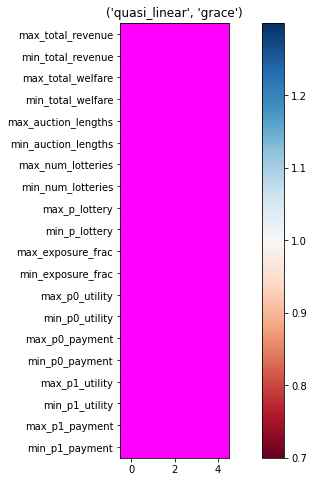

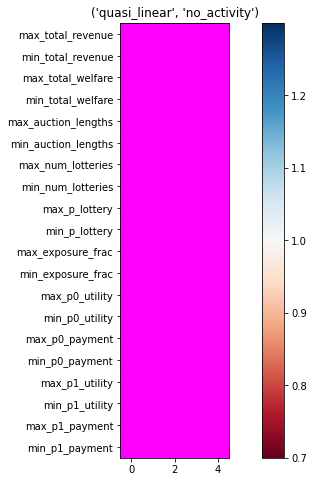

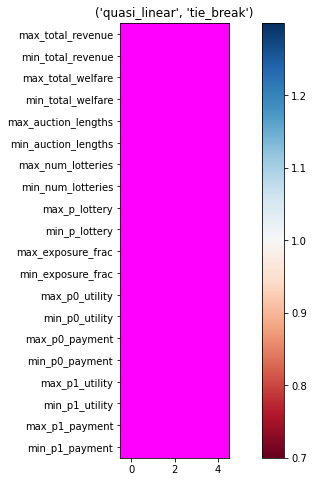

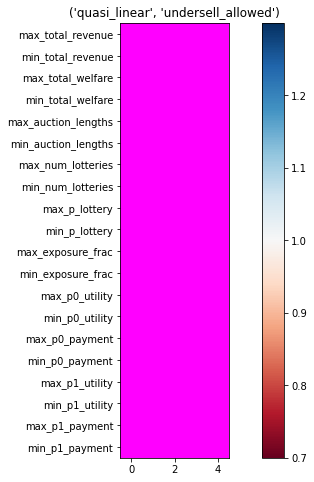

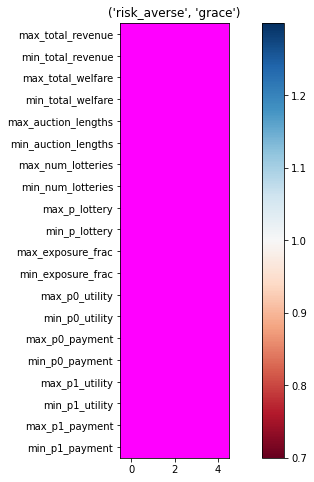

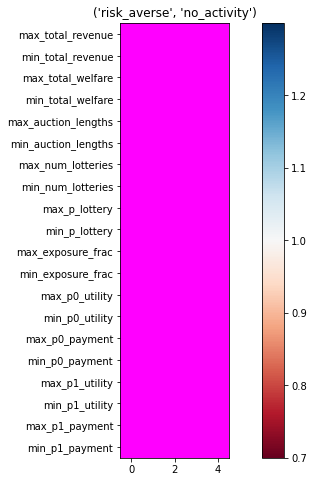

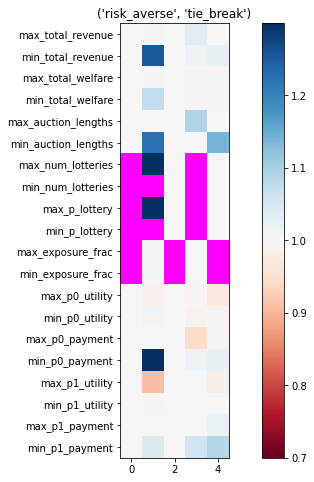

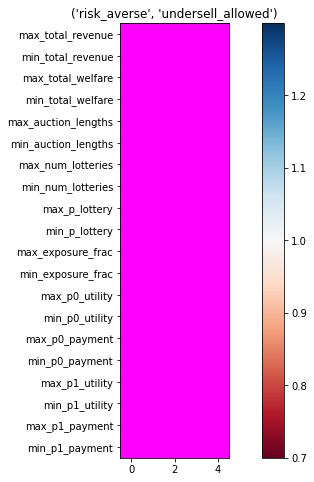

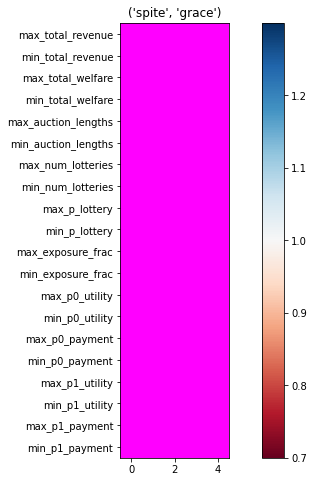

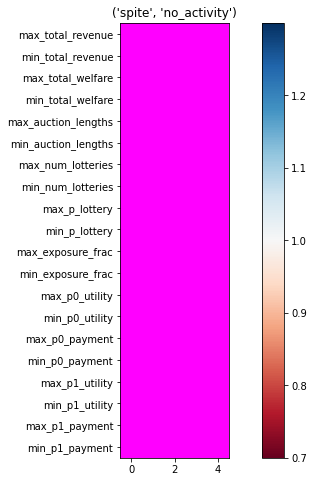

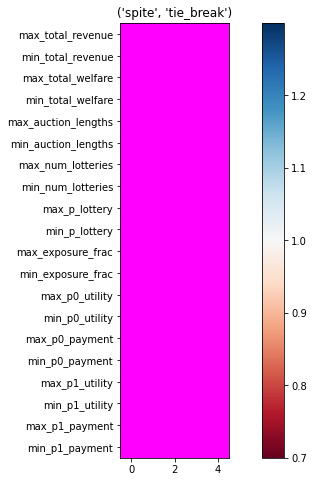

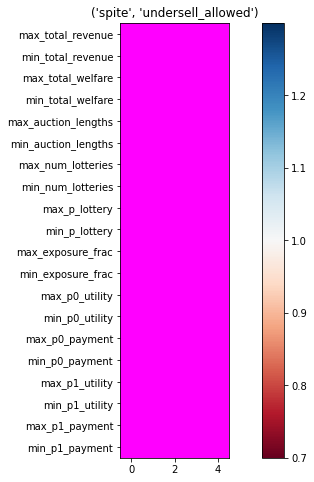

In [29]:
# 1) Get max/min for each valuation/treatment pairing over each stat

# First query down to relevant datapoints. Then groupby rule change and SATS =(game_name) and max/min?
metrics = ['total_revenue', 'total_welfare', 'auction_lengths', 'num_lotteries', 'p_lottery', 'exposure_frac']
for i in range(2): # TODO:
    metrics += [f'p{i}_utility', f'p{i}_payment']


df_plt_indexed = df_plt.set_index(['value_structure', 'rule']).sort_index().copy()

def make_data_dict(df):
    data = dict()
    for metric in metrics:
        data[f'max_{metric}'] = df.groupby('base_game_name')[metric].max()
        data[f'min_{metric}'] = df.groupby('base_game_name')[metric].min()
    return pd.DataFrame(data)
    
for idx, grp_df in df_plt.groupby(['value_structure', 'rule']):
    if idx[1] == 'base':
        continue
        
    try:
        data_grp_df = make_data_dict(grp_df)
        normalizer_grp_df = df_plt_indexed.loc[(idx[0], 'base')]
        data_normalized_df = make_data_dict(normalizer_grp_df)

        cmap_norm = plt.matplotlib.colors.TwoSlopeNorm(vmin=0.7, vcenter=1, vmax=1.3)
        cmap = plt.cm.get_cmap('RdBu').copy()
        cmap.set_bad('magenta')
        plt.figure(figsize=(12, 8))
        data = (data_grp_df / data_normalized_df).values.T
        plt.imshow(data, cmap=cmap, norm=cmap_norm)
        plt.title(idx)
        plt.yticks(range(len(data_grp_df.columns)), data_grp_df.columns)
        plt.colorbar()
        plt.show()
    except Exception as e:
        print(idx, e)

In [ ]:
ATTRIBUTE = 'variant'
NORMALIZED = False
plot_type = 'scatter'
box_df = df_plt.copy()
markers = ['o', 'X', '^']

# TODO: These strings are getting unwieldy

# Vanilla for clock
CLOCK_QUERY = 'information_policy == "SHOW_DEMAND" and activity_policy == "ON" and undersell_policy == "UNDERSELL" and grace_rounds == 1 and tiebreaking_policy == "DROP_BY_PLAYER"'
# box_df = box_df.query(CLOCK_QUERY)

# # Check undersell
UNDERSELL_QUERY = 'information_policy == "SHOW_DEMAND" and activity_policy == "ON" and clock_speed == 0.3 and grace_rounds == 1'
# box_df = box_df.query(UNDERSELL_QUERY)

# # Check activity
ACTIVITY_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and grace_rounds == 1'
# box_df = box_df.query(ACACTIVITY_QUERY)

# # Check tiebreaking
TIEBREAKING_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and activity_policy == "ON" and grace_rounds == 1'
# box_df = box_df.query(TIEBREAKING_QUERY)

# Check grace
GRACE_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and activity_policy == "ON" and tiebreaking_policy == "DROP_BY_PLAYER" and not risk_aversion'
# box_df = box_df.query(GRACE_QUERY)

# Activity ON vs grace vs activity OFF
box_df = box_df.query('information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and tiebreaking_policy == "DROP_BY_PLAYER" and not risk_aversion')


box_df = box_df.sort_values(['clock_speed', 'game_name', 'config'])

# box_df = box_df.query('alg.str.contains("outcome")')

print(len(box_df))


STATS = ['total_revenue', 'total_welfare', 'auction_lengths']
# Normalize by the mean of the "base" version, so the scales line up better in the same graph
if NORMALIZED: 
    for stat in STATS:
        base = str(('SHOW_DEMAND', 0.3))
        base_stat = box_df.pivot_table(index=['base_game_name'], values=stat, aggfunc='mean', columns=ATTRIBUTE)
        box_df[f'normalized_{stat}'] = box_df.apply(lambda x: x[stat] / base_stat.loc[x['base_game_name'], base], axis=1)

for stat in STATS:
    if NORMALIZED:
        stat = f'normalized_{stat}'
    plt.figure(figsize=(20,10))
    if plot_type == 'box':
        ax = sns.boxplot(data=box_df, x='base_game_name', y=stat, hue=ATTRIBUTE)
        # ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    else:
        strip_kwargs = dict(x='base_game_name', y=stat, hue=ATTRIBUTE, s=10, alpha=0.5, dodge=True, jitter=False, palette=palette)
        sns.stripplot(data=box_df, **strip_kwargs)
        # for i, config in enumerate(box_df['config'].unique()):
        #     # print(config, markers[i])
        #     # TODO: If no entries exist, this pushes colours to the wrong positions
        #     ax = sns.stripplot(data=box_df.query(f'config == "{config}"'), marker=markers[i], **strip_kwargs)
        #     if i == 0:
        #         old_handles, old_labels = ax.get_legend_handles_labels()
        # ax.legend(old_handles, old_labels)

    plt.title(f"{stat}")

In [20]:
### This is the cell you run when you want to rerun evals 
run_names_to_reeval = df.query('(rule == "tie_break" or rule == "base") and value_structure == "risk_averse"')['run_name'].values
overwrite_existing = True
for run in tqdm(run_names_to_reeval):
    run = EquilibriumSolverRun.objects.get(name=run, experiment__name=experiment)
    try:
        game, final_checkpoint, policy = get_results(run, load_policy=False)
    except Exception as e:
        print(f"Skipping run {run.name} because of error {e}")
        continue

    try:
        ev = final_checkpoint.get_modal_eval()
        if not pd.isnull(ev.nash_conv) and not overwrite_existing:
            continue
        else:
            ev.delete()
    except Exception as e:
        ev = None

    br_mapping = {p: 'modal' for p in range(2)}
    dispatch.dispatch_eval_database(final_checkpoint.t, run.experiment.name, run.name, str(br_mapping))


  3%|█████▌                                                                                                                                                                | 2/60 [00:00<00:07,  7.81it/s]

Submitted batch job 99536
Submitted batch job 99537


  7%|███████████                                                                                                                                                           | 4/60 [00:00<00:11,  4.79it/s]

Submitted batch job 99538
Submitted batch job 99539


 10%|████████████████▌                                                                                                                                                     | 6/60 [00:01<00:12,  4.30it/s]

Submitted batch job 99540
Submitted batch job 99541


 12%|███████████████████▎                                                                                                                                                  | 7/60 [00:01<00:10,  4.95it/s]

Submitted batch job 99542


 15%|████████████████████████▉                                                                                                                                             | 9/60 [00:02<00:11,  4.53it/s]

Submitted batch job 99543
Submitted batch job 99544


 18%|██████████████████████████████▏                                                                                                                                      | 11/60 [00:02<00:11,  4.44it/s]

Submitted batch job 99545
Submitted batch job 99546


 22%|███████████████████████████████████▊                                                                                                                                 | 13/60 [00:02<00:07,  6.02it/s]

Submitted batch job 99547
Submitted batch job 99548


 25%|█████████████████████████████████████████▎                                                                                                                           | 15/60 [00:03<00:08,  5.01it/s]

Submitted batch job 99549
Submitted batch job 99550


 28%|██████████████████████████████████████████████▊                                                                                                                      | 17/60 [00:03<00:09,  4.49it/s]

Submitted batch job 99551
Submitted batch job 99552


 30%|█████████████████████████████████████████████████▌                                                                                                                   | 18/60 [00:03<00:08,  5.09it/s]

Submitted batch job 99553


 33%|███████████████████████████████████████████████████████                                                                                                              | 20/60 [00:04<00:08,  4.46it/s]

Submitted batch job 99554
Submitted batch job 99555


 37%|████████████████████████████████████████████████████████████▍                                                                                                        | 22/60 [00:05<00:09,  4.20it/s]

Submitted batch job 99556
Submitted batch job 99557


 38%|███████████████████████████████████████████████████████████████▎                                                                                                     | 23/60 [00:05<00:07,  4.85it/s]

Submitted batch job 99558


 42%|████████████████████████████████████████████████████████████████████▊                                                                                                | 25/60 [00:05<00:07,  4.57it/s]

Submitted batch job 99559
Submitted batch job 99560


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                             | 26/60 [00:05<00:06,  5.22it/s]

Submitted batch job 99561


 47%|█████████████████████████████████████████████████████████████████████████████                                                                                        | 28/60 [00:06<00:06,  4.67it/s]

Submitted batch job 99562
Submitted batch job 99563


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 30/60 [00:06<00:06,  4.49it/s]

Submitted batch job 99564
Submitted batch job 99565


 52%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 31/60 [00:06<00:05,  5.15it/s]

Submitted batch job 99566


 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 33/60 [00:07<00:05,  4.69it/s]

Submitted batch job 99567
Submitted batch job 99568


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 34/60 [00:07<00:04,  5.48it/s]

Submitted batch job 99569


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 36/60 [00:08<00:05,  4.66it/s]

Submitted batch job 99570
Submitted batch job 99571


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 37/60 [00:08<00:04,  5.13it/s]

Submitted batch job 99572


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 39/60 [00:08<00:04,  4.51it/s]

Submitted batch job 99573
Submitted batch job 99574


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 41/60 [00:09<00:04,  4.39it/s]

Submitted batch job 99575
Submitted batch job 99576


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 42/60 [00:09<00:03,  5.20it/s]

Submitted batch job 99577


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 44/60 [00:09<00:03,  4.56it/s]

Submitted batch job 99578
Submitted batch job 99579


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 46/60 [00:10<00:03,  4.25it/s]

Submitted batch job 99580
Submitted batch job 99581


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 47/60 [00:10<00:02,  4.91it/s]

Submitted batch job 99582


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 49/60 [00:11<00:02,  4.66it/s]

Submitted batch job 99583
Submitted batch job 99584


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 50/60 [00:11<00:01,  5.45it/s]

Submitted batch job 99585


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 52/60 [00:11<00:01,  4.90it/s]

Submitted batch job 99586
Submitted batch job 99587


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 54/60 [00:11<00:00,  6.36it/s]

Submitted batch job 99588
Submitted batch job 99589


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 56/60 [00:12<00:00,  5.22it/s]

Submitted batch job 99590
Submitted batch job 99591


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 57/60 [00:12<00:00,  5.85it/s]

Submitted batch job 99592


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:13<00:00,  5.00it/s]

Submitted batch job 99593
Submitted batch job 99594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.55it/s]

Submitted batch job 99595
